### Isthmuslib tutorial

This document will show how to use isthmuslib functions and objects for creating high-quality visualizations and easily manipulating high-dimensional vector sequencies (i.e. multivariate timeseries).

## Set up notebook

Import libraries (including `isthmuslib`)

In [1]:
import src.isthmuslib as isli
import numpy as np
import pandas as pd
from typing import List, Dict, Callable, Tuple
import pathlib
from matplotlib import cycler
from copy import deepcopy

Tweak to disable scrolling in the notebook

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import warnings
warnings.filterwarnings("ignore")

### OPTIONAL: create a `Style` object with visual configuration parameters

If you have a desired color scheme or figure style, you can define it once and then pass that object through to everything else

In [4]:
style: isli.Style = isli.Style(    
    color = 'DarkGreen',
    facecolor = 'w',
    title_fontsize = 18.0,
    label_fontsize = 15.0,
    legend_fontsize = 15.0,
    tick_fontsize = 12.0,
    figsize = (10.0, 8.0),
    linewidth = 5.0,
    linestyle = '-',
    grid = True,
    tight_axes = True,
    formatter = '%Y-%m-%d %H:%M:%S',
    markersize = 50,
    transparent_alpha = 0.5,
    watermark_placement = (0.05, 0.05),
    watermark_fontsize = 20,
    watermark_color = 'dimgrey',
    watermark_text = 'Isthmuslib tutorial',
    histogram_bins = 25,
    multi_hist_alpha = 0.5,
    median_linestyle = '--',
    median_linewidth = 3.0,
    median_linecolor = 'k',
    mean_linestyle = '-',
    mean_linewidth = 3.0,
    mean_linecolor = 'k',
    cycler = cycler(color=['r', 'g', 'b', 'y']) + cycler(linestyle=['-', '--', ':', '-.']),
    good_color = 'navy',
    bad_color = 'firebrick',
    cmap = 'inferno',
    sequential_cmap = 'Greens',
)

We can also include a `Rosetta` object that will be automatically used to translate autolabels

In [5]:
style.rosetta = isli.Rosetta(stone={
    'timestamp_sec': 'Timestamp (seconds)',
    'foo': 'Foo experiment',
    'baz': 'Baz (control case)'
    })

# For example
style.translate('baz')

'Baz (control case)'

# Plotting data

First, let's make up some random sample data...

In [6]:
normal_randomness: Callable[[], np.ndarray] = lambda: np.random.normal(size=1000)
np.random.seed(0)
data_1: np.ndarray = normal_randomness()
data_2: np.ndarray = [1 + x / 2 for x in data_1]
data_3: np.ndarray = normal_randomness()
data_4: np.ndarray = normal_randomness()

## Visualize 1D Histogram

This function wraps `matplotlib.pyplot`'s histogram function, applies labels, and styling. Additional keyword arguments (e.g. `bins`) are passed through to the underlying `hist` function.

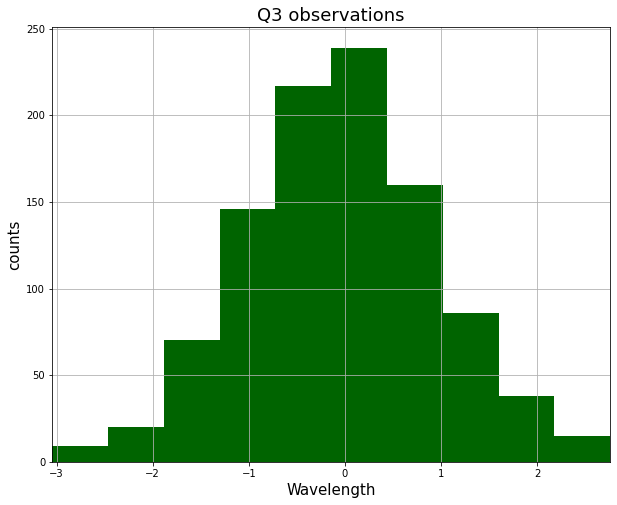

In [7]:
isli.hist(data_1, xlabel='Wavelength', title='Q3 observations');

We can also plot multiple distributions at once by putting them in a list.

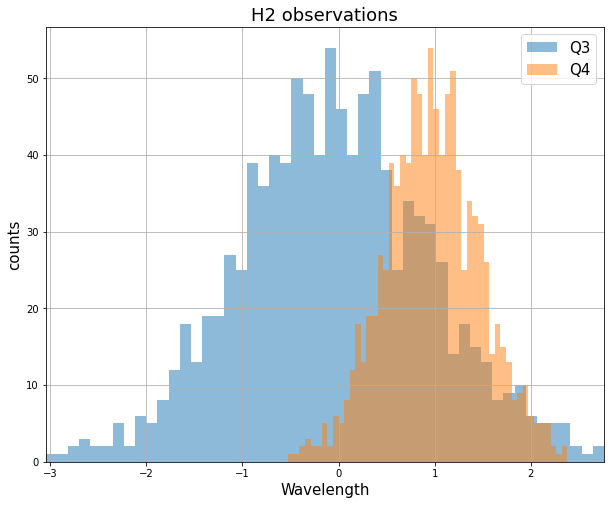

In [8]:
isli.hist([data_1, data_2], xlabel='Wavelength', title='H2 observations', 
          legend_strings=["Q3", "Q4"], bins=50);

We can add any `matplotlib.pyplot.hist()` kwargs, e.g. `density` and `cumulative` and `bins`. Note that the y-axis label automatically updates to convey such adjustments. We'll also pass in the optional `Style` object defined above to change the color scheme and apply a watermark.

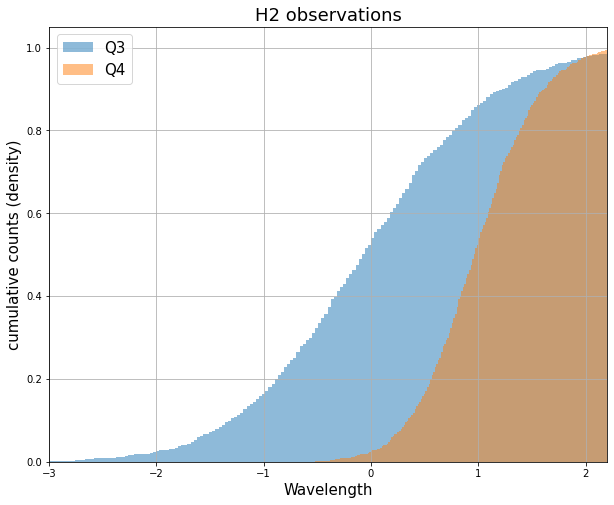

In [9]:
isli.hist([data_1, data_2], xlabel='Wavelength', title='H2 observations', legend_strings=["Q3", "Q4"], bins=200,
          density=True, cumulative=True, xlim=(-3, 2.2));

Note that if you have a data frame handy, you can simply pass the dataframe and column titles into `hist()` and it will automatically pull out the features and labels.

In [10]:
df: pd.DataFrame = pd.read_csv(pathlib.Path.cwd() / 'data' / 'version_controlled' / 'example_vector_sequence_data.csv')
df.head()

,timestamp,foo,bar,baz
0,1577689200,0.06000,0.039367,0.04800
1,1577602800,0.05940,0.039600,0.04752
2,1577516400,0.06000,0.040000,0.04828
3,1577430000,0.05895,0.039767,0.04772
4,1577343600,0.05980,0.039600,0.04948


Note that while we simply input `['foo', 'bar']` to, the isthmuslib wrapper automatically applies the translations from our custom `style` to the legend strings. This ensures consistency across all axis and legend labeling.

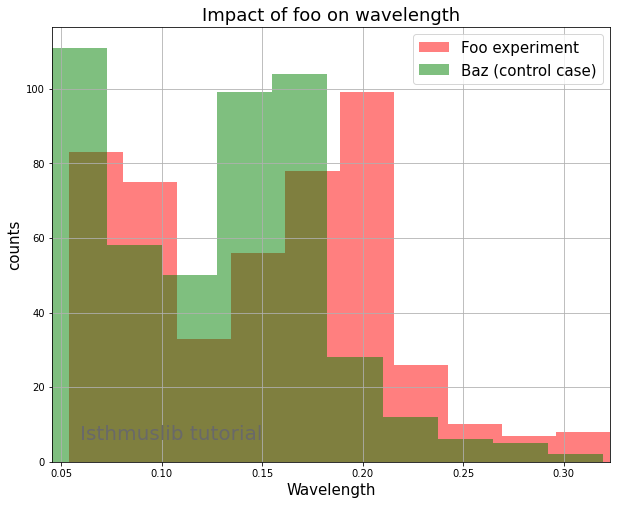

In [11]:
isli.hist(df, ['foo', 'baz'], style=style, title='Impact of foo on wavelength', xlabel='Wavelength');

## Visualize 2D data

The 2D plots wrap `matplotlib.pyplot`'s `plot` and `scatter` functions.

For plotting a single trace, the matplotilb syntax works.

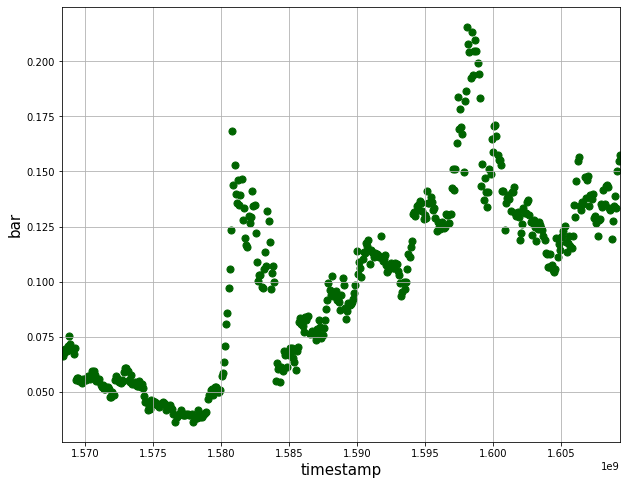

In [12]:
isli.scatter(df.timestamp, df.bar, xlabel='timestamp', ylabel='bar', style=style, watermark_text='');

(we can feed multiple data sets in as well)

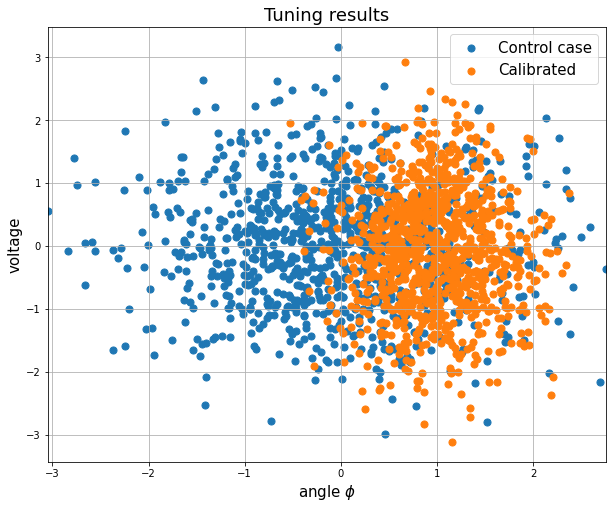

In [13]:
isli.scatter([data_1, data_2], [data_3, data_4], xlabel='angle $\phi$', ylabel='voltage', title='Tuning results',
             legend_strings=['Control case', 'Calibrated']);

We can also cast a single x & y vector pair into a 2D histogram (essentially a surface with height [color] showing bin counts).

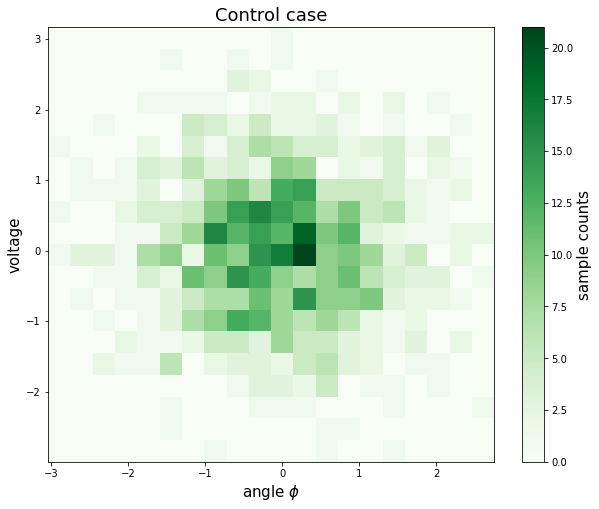

In [14]:
isli.hist2d(data_1, data_3, xlabel='angle $\phi$', ylabel='voltage', title='Control case', bins=(20, 20),
            colorbar_label='sample counts');

## Working with vectors and timeseries

We can also load a dataframe or CSV file into the `VectorSequence` class for working with multivariate timeseries and similarly shaped data with some physically-interpretable strictly ordered axis, for example:
+ Multiple physical features (temperature, pressure, and irradiation) measured simultaneously at 3 different heights
+ Multiple stock values observed over time
+ Fluorescence intensity measured simultaneously at different wavelengths

If the data does _not_ have an inherent ordering, use the isthmuslib `VectorMultiSet` instead of the `VectorSequence`.

In [15]:
timeseries: isli.VectorSequence = isli.VectorSequence().read_csv(
    pathlib.Path.cwd() / 'data' / 'version_controlled' / 'example_vector_sequence_data.csv', inplace=False,
    basis_col_name='timestamp', name_root='Experiment gamma')
type(timeseries)

src.isthmuslib.vectors.VectorSequence

The data is stored in a dataframe, so any pandas style calls and commands are available, for example:

In [16]:
timeseries.data.sort_values(by='foo', ascending=True, inplace=False).head(15)

,timestamp,foo,bar,baz
112,1578034800,0.05380,0.038067,0.05024
97,1576652400,0.05460,0.039700,0.04852
110,1577862000,0.05650,0.040167,0.04820
111,1577948400,0.05665,0.036333,0.04536
115,1578294000,0.05715,0.041900,0.05028
114,1578207600,0.05735,0.038233,0.04800
99,1576825200,0.05800,0.039600,0.04800
113,1578121200,0.05815,0.038033,0.04652
118,1578553200,0.05830,0.038600,0.04800
119,1578639600,0.05850,0.039633,0.04756


In [17]:
timeseries.data.describe()

,timestamp,foo,bar,baz
count,4.750000e+02,475.000000,475.000000,475.000000
mean,1.588813e+09,0.149973,0.100131,0.127152
std,1.188621e+07,0.061196,0.040855,0.053413
min,1.568268e+09,0.053800,0.036333,0.045360
25%,1.578596e+09,0.088000,0.057783,0.076160
50%,1.588831e+09,0.158550,0.106033,0.133480
75%,1.599070e+09,0.196900,0.130900,0.166000
max,1.609312e+09,0.323150,0.215700,0.319520


The `isthmuslib` plotting features demoed above are directly attached to the vector multiset & sequence objects.

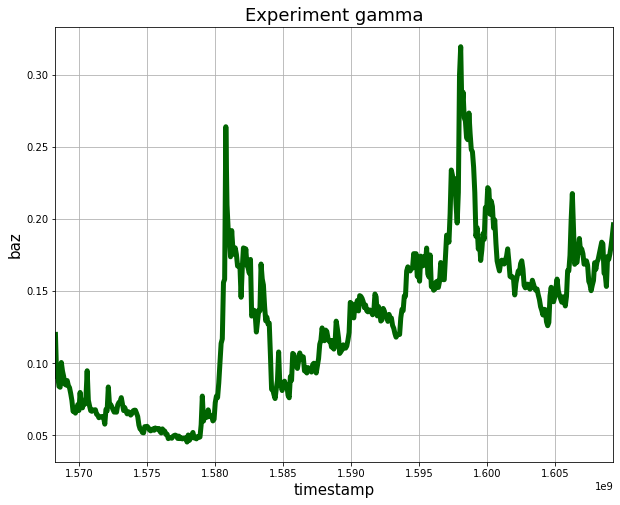

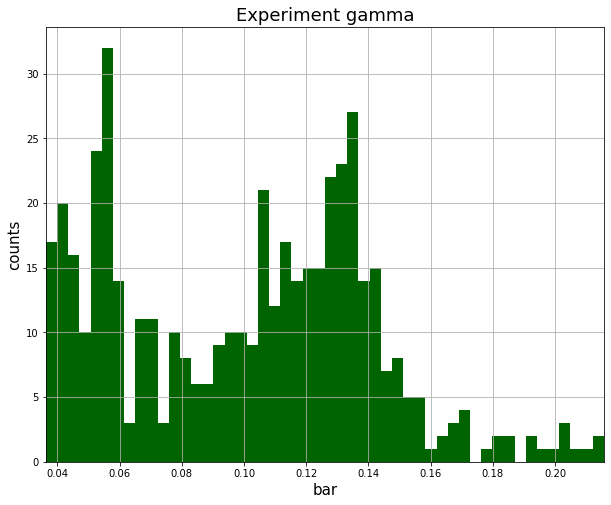

In [18]:
timeseries.plot('baz');
timeseries.hist('bar', bins=50);

### Downsampling
Note that we have multiple methods for downsampling (which is best depends on the context of the basis and the tasks/questions at hand)

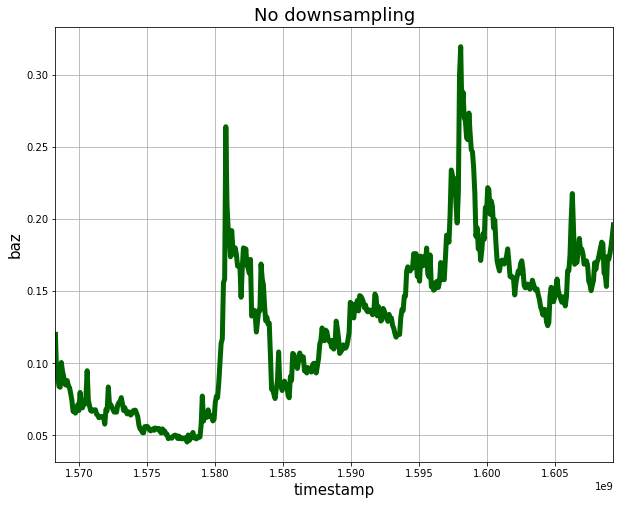

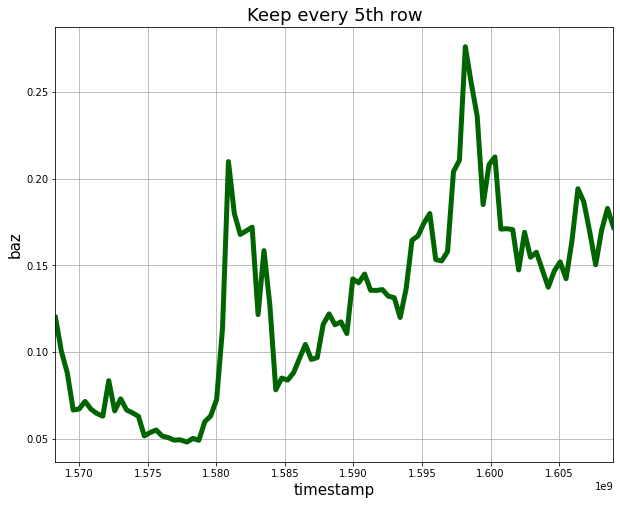

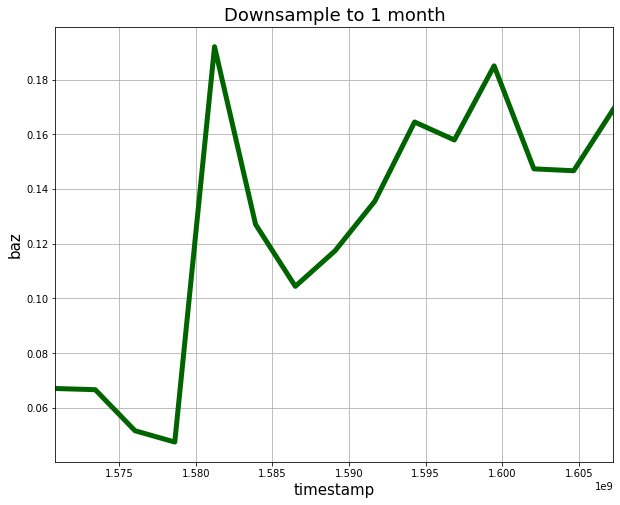

In [19]:
timeseries.plot('baz', title='No downsampling');
deepcopy(timeseries).downsample(interval=5, inplace=False, method='by_row').plot('baz', title='Keep every 5th row');
deepcopy(timeseries).downsample(interval=30 * 24 * 60 * 60, inplace=False, method='by_basis').plot('baz', title='Downsample to 1 month');

### Correlation matrix
We can take a peek at correlation between the columns (wraps `corr` from `pandas`).

In [20]:
timeseries.correlation_matrix()

,foo,bar,baz
foo,1.000000,0.984397,0.981937
bar,0.984397,1.000000,0.987553
baz,0.981937,0.987553,1.000000


### Periodicity / seasonality analysis
We can visualize seasonal decomposition analyses with a single line, wrapping `statsmodel.tsa` logic with styled plots.

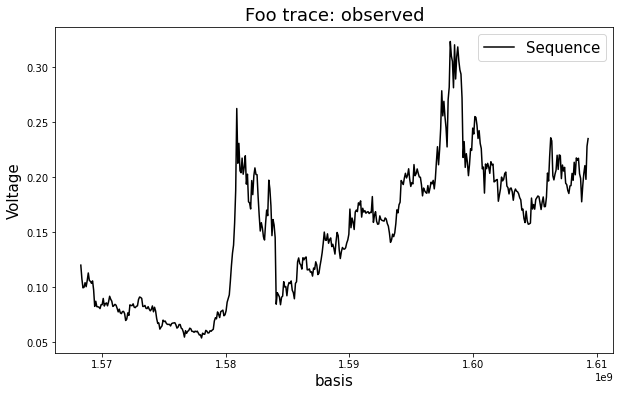

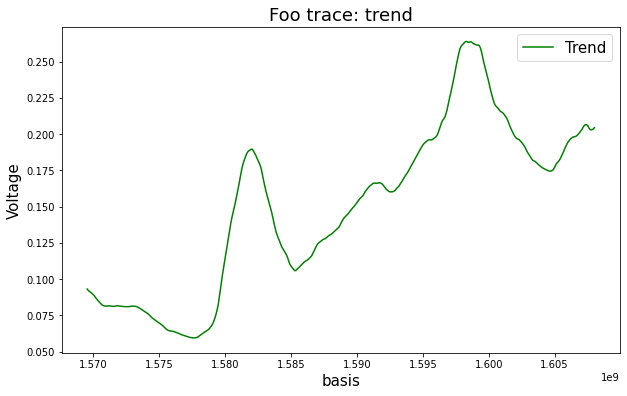

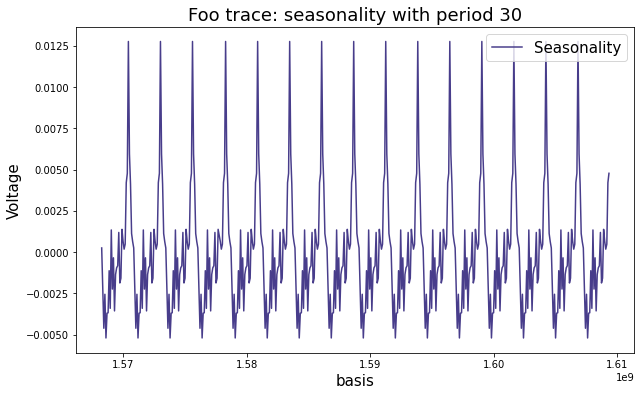

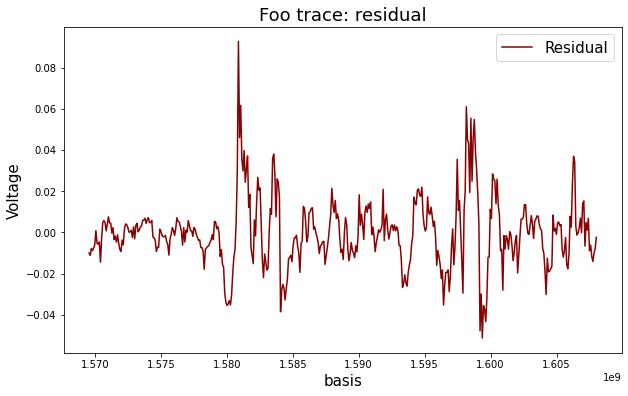

In [21]:
timeseries.plot_decomposition('foo', 30, figsize=(10, 6), title='Foo trace: ', ylabel='Voltage');

### Sliding window analyses

The VectorSequence timeseries class contains logic for sliding window analyses with arbitrary functions. Here we'll use a throwaway lambda `appreciation` to demonstrate.

In [22]:
def appreciation_lambda(o: isli.VectorSequence):
    return {'Change in value (%)': 100 * (o.values('foo')[-1] / o.values('foo')[0] - 1)}

Apply the function over sliding windows with 2, 4, and 8 week durations:

In [23]:
window_widths_weeks: List[float] = [2, 4, 8]
result: isli.SlidingWindowResults = timeseries.sliding_window(appreciation_lambda,
                                                              [x * 60 * 60 * 24 * 7 for x in window_widths_weeks],
                                                              parallelize_sliding_window=True)

The `SlidingWindowResult.plot_results()` method automatically plots results separated by window width.

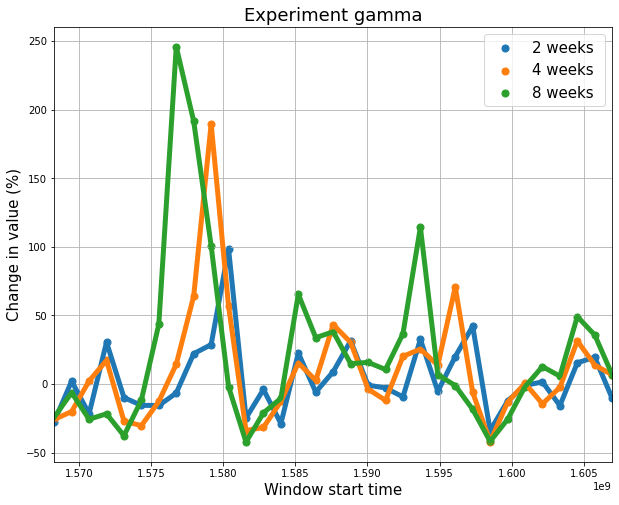

In [24]:
f = result.plot_results('Change in value (%)', legend_override=[f"{x} weeks " for x in window_widths_weeks]);

Likewise, the `sliding_window.plot_pdfs()` method plots distributions separated by window width.

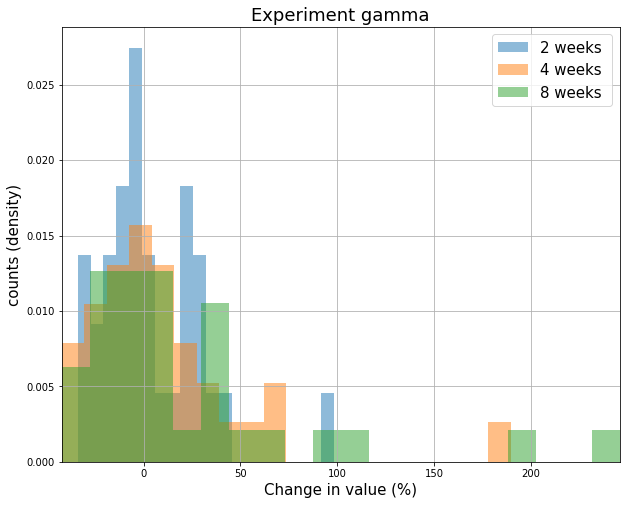

In [25]:
result.plot_pdfs('Change in value (%)', density=True, bins=20,
                 legend_override=[f"{x} weeks " for x in window_widths_weeks]);

Since this wraps the histogram function shown above, `cumulative=True` produces the CDF.

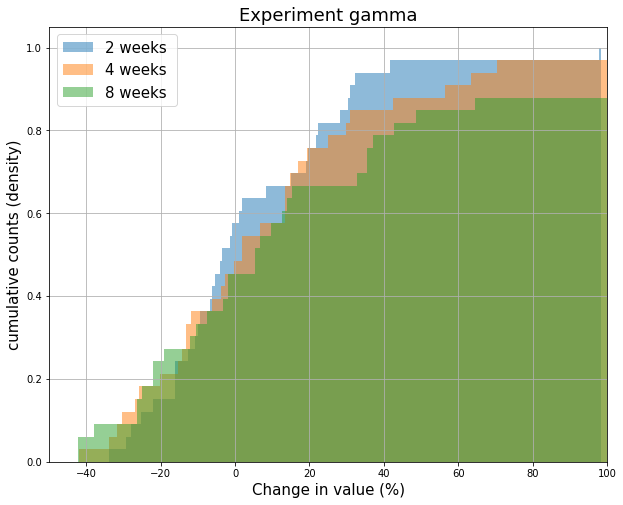

In [26]:
result.plot_pdfs('Change in value (%)', density=True, cumulative=True, bins = 200,
                 legend_override=[f"{x} weeks " for x in window_widths_weeks], xlim=[-50,100]);

## Dimensionality reduction and information content analyses

Dimensionality reduction (SVD) logic over sliding windows is built into the `VectorSequence` class, allowing easy calculation and visualization of information surfaces (first 3 singular value surfaces shown below). The timeseries basis (specified in `basis_col_name`) is automatically excluded from the SVD analysis. The `cols` keyword argument can be specified when only certain data features should be taken into account.

(Note that infosurface calculation is parallelized by default, but this can be suppressed with `parallelize_sliding_window=False` if desired)

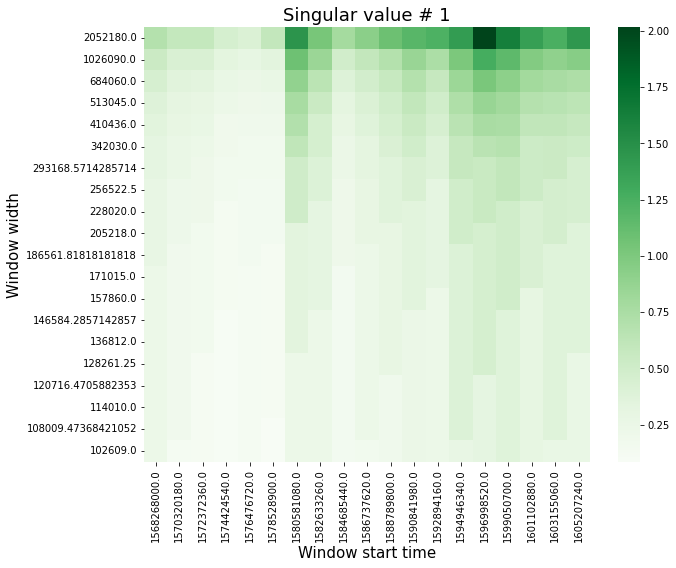

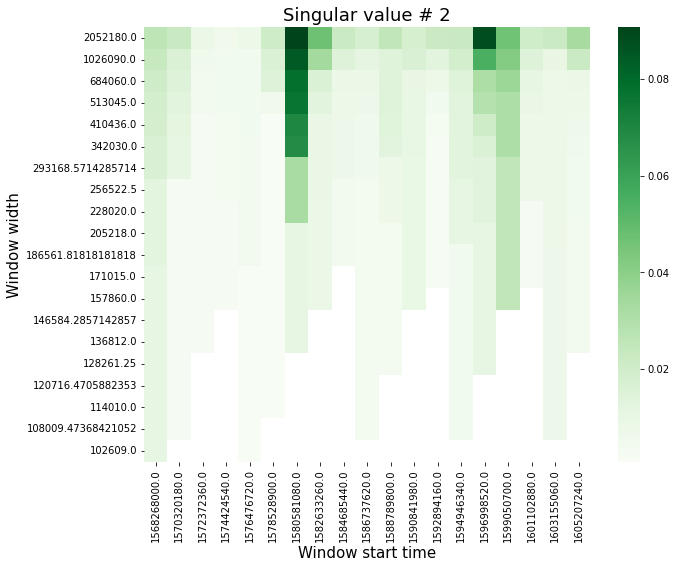

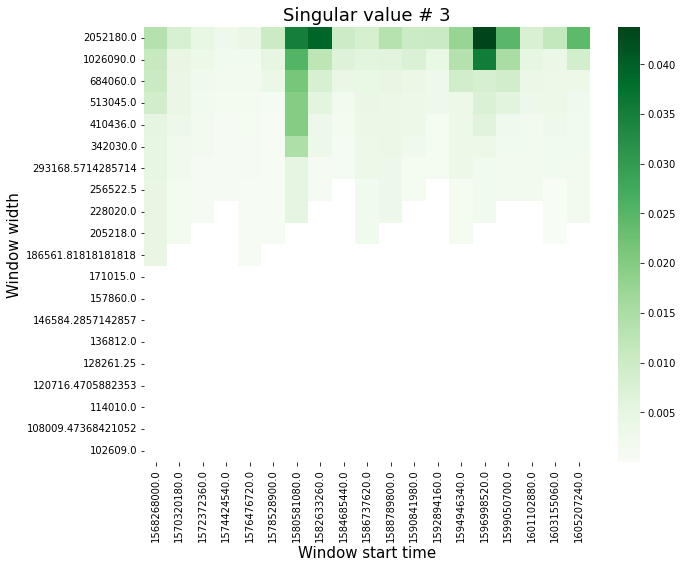

In [27]:
timeseries.plot_info_surface(save_result=True);

Some surfaces are easier to see in pseudo-3D

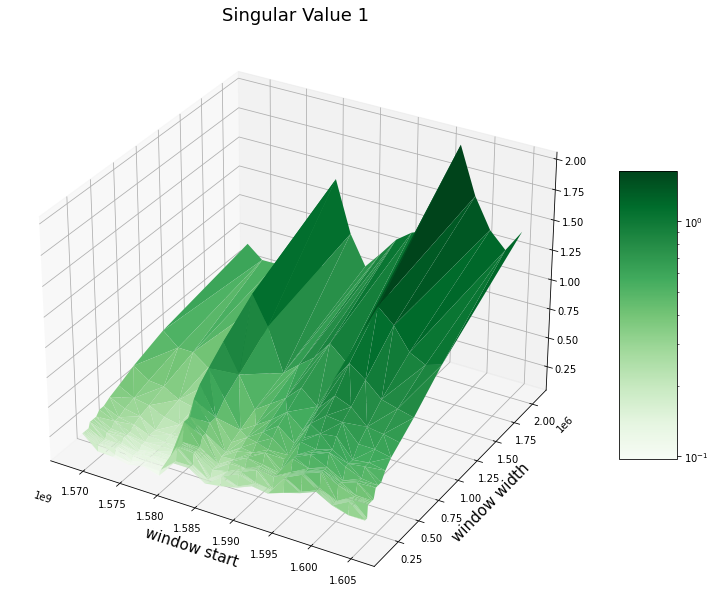

In [28]:
timeseries.info_surface.visualize_embedded_surface(*['window_start', 'window_width', 'singular_value_1'],
                                                  xlabel='window start', ylabel='window width', title='Singular Value 1');

## Matrix profiling

The analyze method and its plots from [MatrixProfile](https://github.com/matrix-profile-foundation/matrixprofile) are attached to the `VectorSequence` and `Timeseries` objects

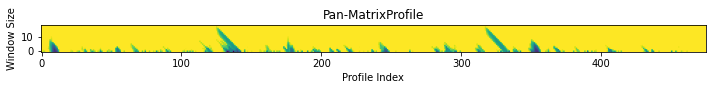

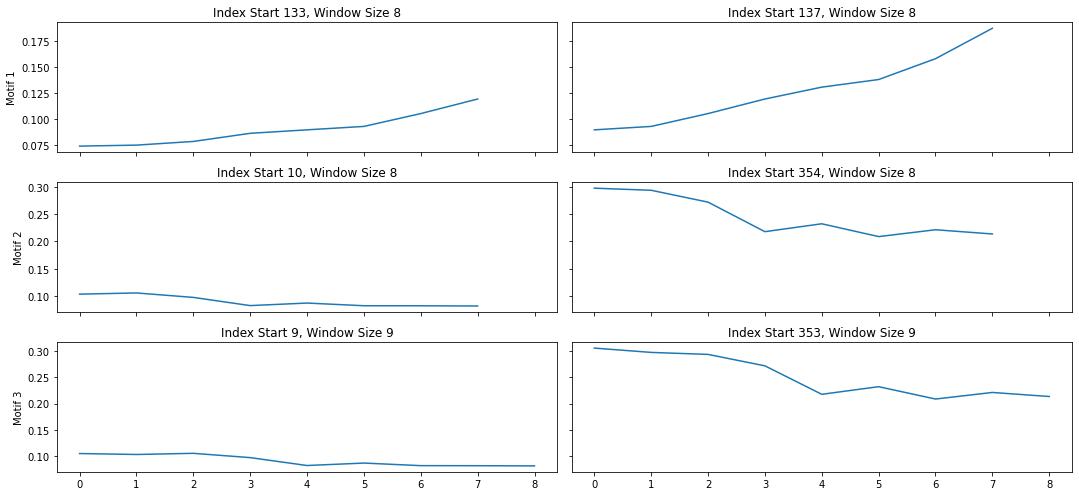

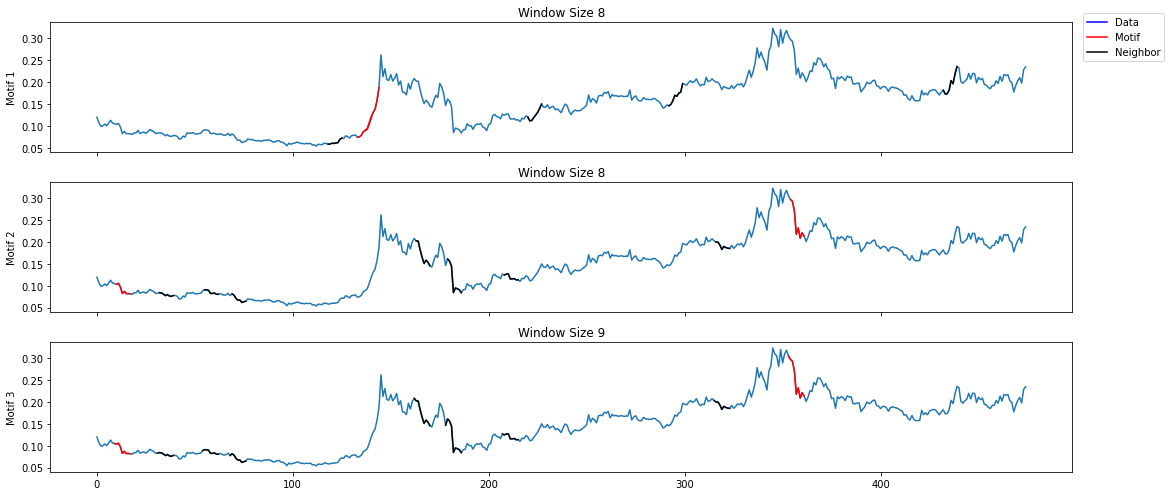

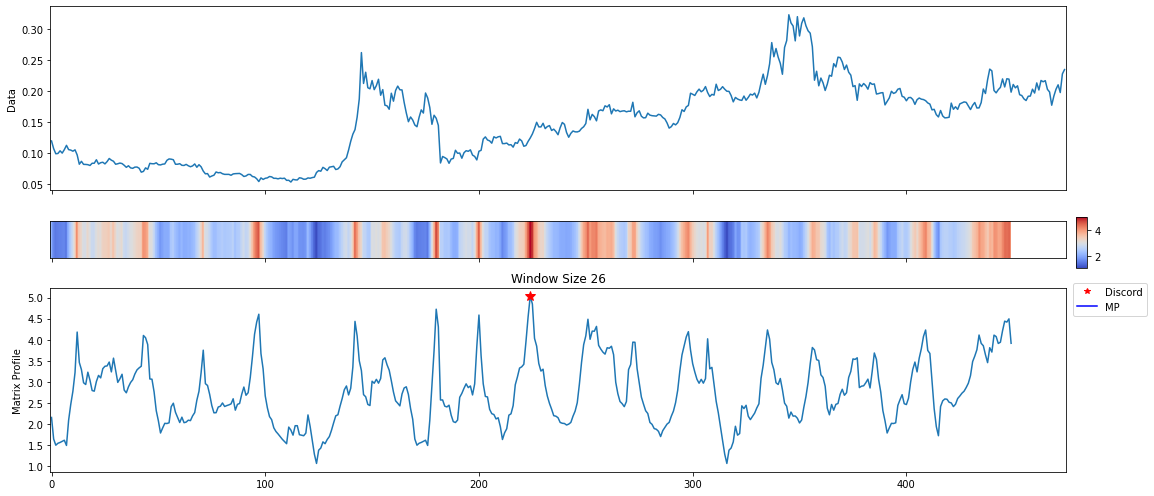

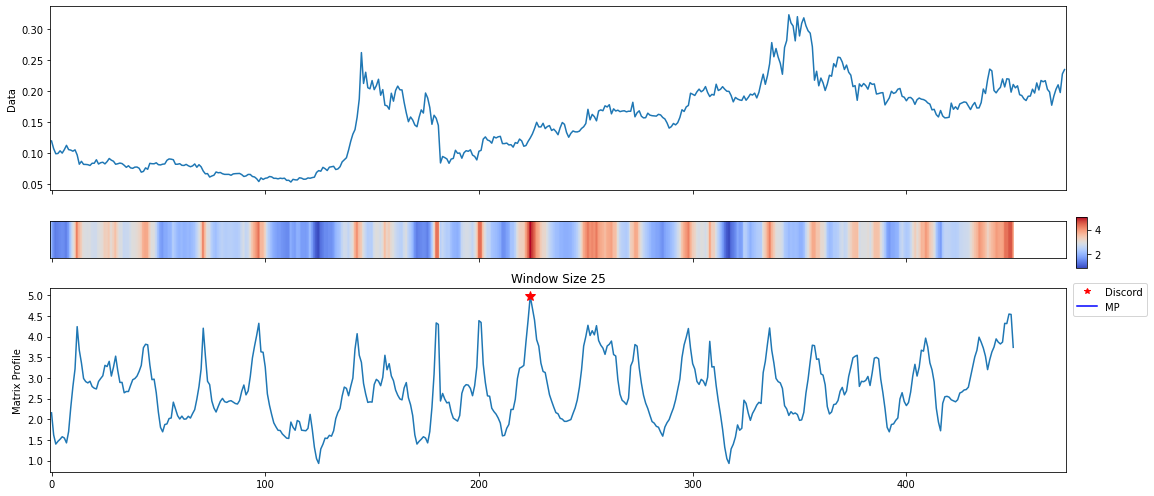

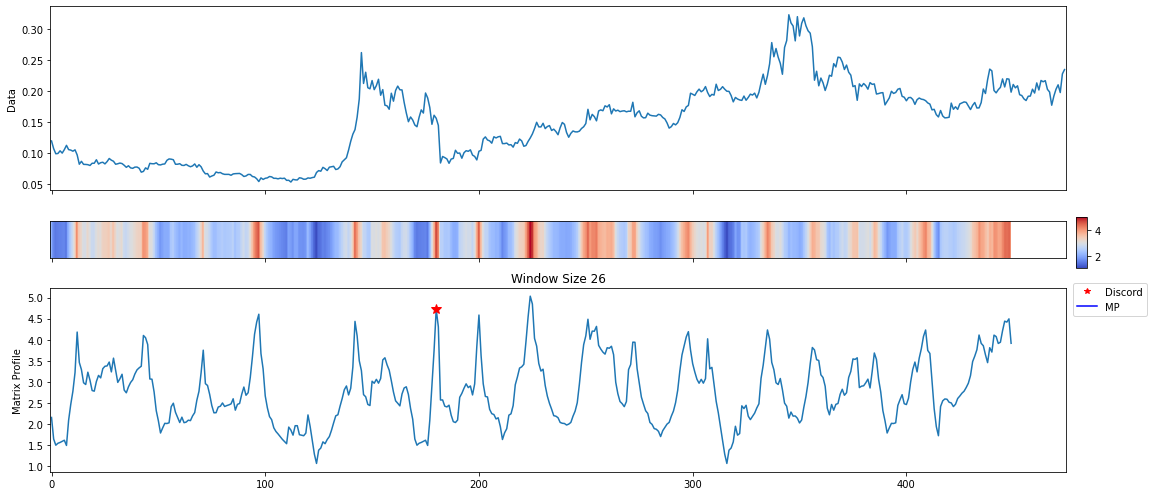

In [29]:
timeseries.matrix_profile_univariate('foo');

It is also easy to access the matrix profiling methods from the [STUMPY library](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html)

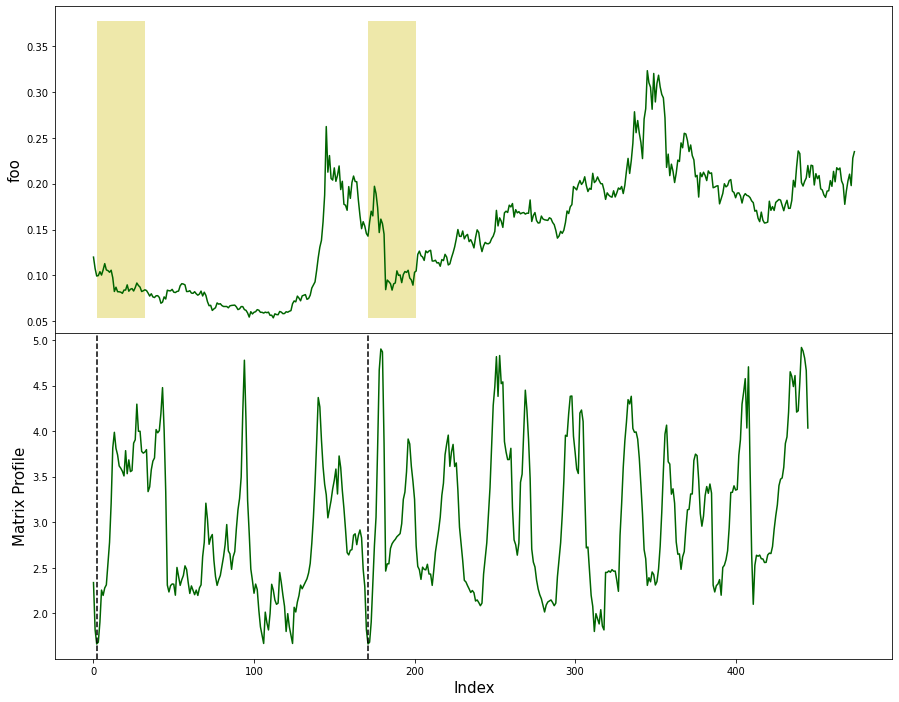

In [30]:
timeseries.stumpy_profile_univariate('foo', window_size=30, annotate_motif=True, figsize=(15,12), title='');

This includes FLUSS Semantic Segmentation

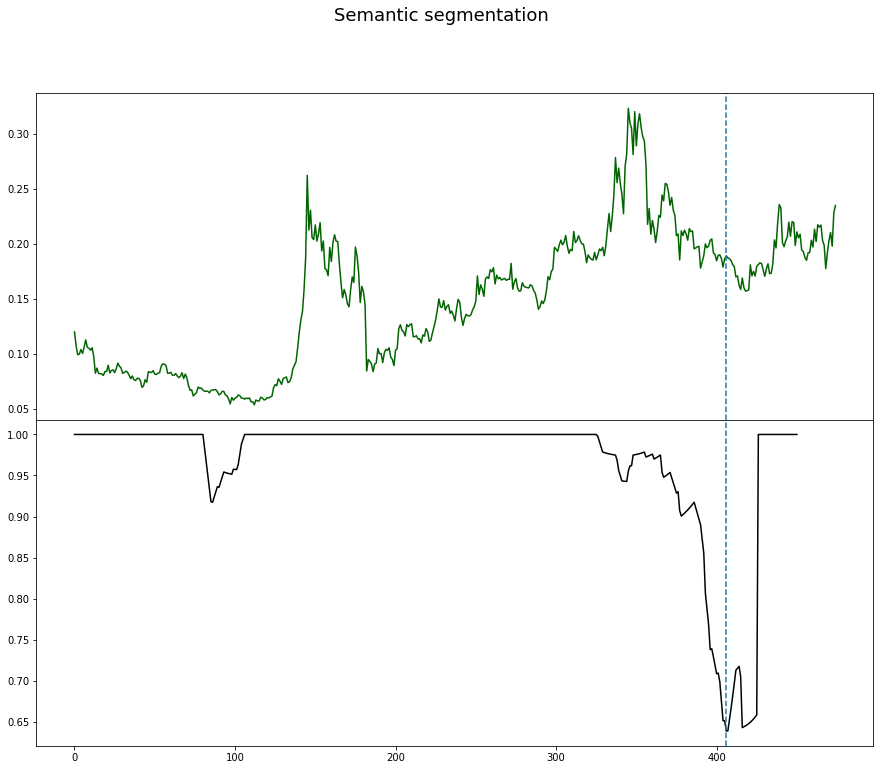

In [31]:
timeseries.plot_fluss_semantic_segmentation('foo', fluss_width=25, figsize=(15,12), title='Semantic segmentation');

# Miscellaneous

The `zero_mean_unit_deviation` helper function does what its name implies. The blue distribution is the input, and the orange is the normalized output.

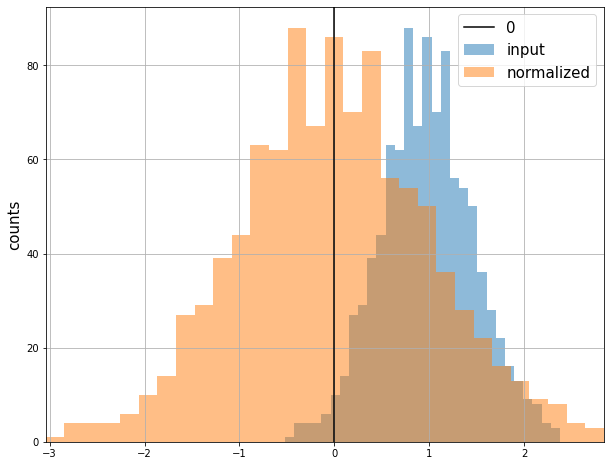

In [32]:
isli.hist([data_2, isli.zero_mean_unit_deviation(data_2)], bins=30, legend_strings=['input','normalized'])
isli.plt.axvline(x=0, color='k')
isli.plt.legend(['0', 'input', 'normalized'], fontsize=style.legend_fontsize);

## Timestamps

We have `human_time` and `machine_time` for easy conversion (wraps `parser` and `datetime`).

In [33]:
isli.machine_time('2021-12-22T08:12:23Z', units='ms')

1640160743000.0

In [34]:
isli.human_time(1511513743, timezone='US/Pacific')

'2017-11-24 00:55:43 (US/Pacific)'

## Data input/output

The vector multiset and sequence support import and export from CSV, feather, pickle, etc.

In [35]:
do_read_write: bool = False

In [36]:
if do_read_write:
    timeseries.to_pickle('output.pickle')

## Log extraction

We can extract data (dataframes, VectorMultiset, VectorSequence) from mostly unstructured text files. You can specify the tokens manually; the library defaults are:

+ `[@@@]` to indicate where a new record starts
+ `[<<`varname`=`value`>>]` to indicate a variable name and value (respectively)

This is designed to play nicely with python fstring `{x=}` notation, e.g. with `x=5`,

`f"hello [<<{x=}>>] world"` --> `'hello [<<x=5>>] world'`

If an entry does not have all fileds, NaNs are recorded for those values in the dataframe core

In [37]:
s: str = """It was the best of times, [@@@] it was the worst [<<x=5>>]of times, it was the age of
wisdom, [<<y='foo'>>] it was the age of foolishness, [@@@] it was the epoch of belief, it was the epoch of 
incredulity, [<<y='bar'>>] it was the season of Light, it was the season of Darkness, """

In [38]:
isli.parse_string_with_key_value_delimiters(s)

  0%|          | 0/3 [00:00<?, ?it/s]

,x,y
0,NaN,NaN
1,5,'foo'
2,NaN,'bar'


Suppose we have some logs that don't conveniently have the automatic tokens...

In [39]:
log: str = """
log-2018-08-31-20-07-29:2018-08-31 20:07:24.748	[P2P2]	INFO protocol_handler.inl:1171	[1;33m[80.241.216.213:18080 OUT]  Synced 49156/1651224 (0.282567 sec, 353.898367 blocks/sec), 99.548294 MB [49255:o][0m
log-2018-08-31-20-07-29:2018-08-31 20:07:25.040	[P2P2]	INFO protocol_handler.inl:1171	[1;33m[80.241.216.213:18080 OUT]  Synced 49256/1651224 (0.291497 sec, 343.056704 blocks/sec), 99.046715 MB [49355:][0m
log-2018-08-31-20-07-29:2018-08-31 20:07:25.280	[P2P2]	INFO protocol_handler.inl:1171	[1;33m[80.241.216.213:18080 OUT]  Synced 49356/1651224 (0.239763 sec, 417.078532 blocks/sec), 98.918274 MB [49455:oo][0m
log-2018-08-31-20-07-29:2018-08-31 20:07:25.644	[P2P2]	INFO protocol_handler.inl:1171	[1;33m[80.241.216.213:18080 OUT]  Synced 49456/1651224 (0.363321 sec, 275.238701 blocks/sec), 98.767830 MB [49555:o.][0m
log-2018-08-31-20-07-29:2018-08-31 20:07:25.981	[P2P2]	INFO protocol_handler.inl:1171	[1;33m[80.241.216.213:18080 OUT]  Synced 49556/1651224 (0.335829 sec, 297.770592 blocks/sec), 98.502403 MB [49655:...][0m
log-2018-08-31-20-07-29:2018-08-31 20:07:26.264	[P2P2]	INFO protocol_handler.inl:1171	[1;33m[80.241.216.213:18080 OUT]  Synced 49656/1651224 (0.281597 sec, 355.117420 blocks/sec), 98.384758 MB [49755:oo....][0m
log-2018-08-31-20-07-29:2018-08-31 20:07:26.776	[P2P2]	INFO protocol_handler.inl:1171	[1;33m[80.241.216.213:18080 OUT]  Synced 49756/1651224 (0.404512 sec, 247.211455 blocks/sec), 98.054283 MB [49855:oo.....][0m
log-2018-08-31-20-07-29:2018-08-31 20:07:27.066	[P2P2]	INFO protocol_handler.inl:1171	[1;33m[80.241.216.213:18080 OUT]  Synced 49856/1651224 (0.289512 sec, 345.408826 blocks/sec), 98.258347 MB [49955:oo.....][0m
"""

In [40]:
# Set the rules for extracting the vectors
record_delimiter: str = 'lo'
tokens_dictionary: Dict[str, Tuple[str,str]] = {
    #varname: (left_token, right_token)
    'date_time_stamp': ('g-',':'),
    'height': ('Synced ', '/'),
    'time_to_load': ('(', ' sec'),
}

# Extract the text into a timeseries
log_timeseries: isli.VectorMultiset = isli.VectorMultiset(data=isli.parse_string_with_manual_tokens(log, 
                                                              record_delimiter=record_delimiter,
                                                              parallelize_processing=True,
                                                              disable_progress_bar=True,
                                                              tokens_dictionary=tokens_dictionary))
# Peek the result
log_timeseries.data

,date_time_stamp,height,time_to_load
0,2018-08-31-20-07-29,49156,0.282567
1,2018-08-31-20-07-29,49256,0.291497
2,2018-08-31-20-07-29,49356,0.239763
3,2018-08-31-20-07-29,49456,0.363321
4,2018-08-31-20-07-29,49556,0.335829
5,2018-08-31-20-07-29,49656,0.281597
6,2018-08-31-20-07-29,49756,0.404512
7,2018-08-31-20-07-29,49856,0.289512


Of course we can easily plot the result with the methods attached to the timeseries

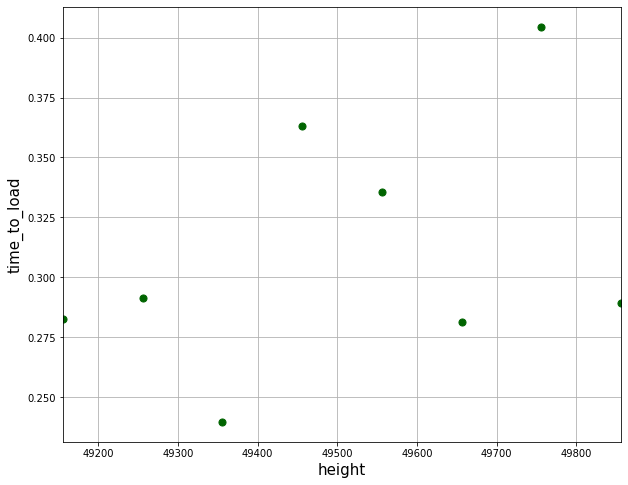

In [41]:
log_timeseries.data['time_to_load'] = log_timeseries.data['time_to_load'].astype(float)
log_timeseries.scatter('height','time_to_load');

Embedded JSON files can also be extracted into dataframes

In [42]:
s: str = """The quick
[[EMBEDDED_JSON_LINE]]{"color": "red", "value": "#f00"}
Brown fox jumped 
[[EMBEDDED_JSON_LINE]]{"color": "green", "value": "#0f0"}
[[EMBEDDED_JSON_LINE]]{"color": "blue", "value": "#00f"}
Over the foobar
[[EMBEDDED_JSON_LINE]]{"color": "cyan", "value": "#0ff"}
[[EMBEDDED_JSON_LINE]]{"color": "black", "value": "#000"}
"""
    
isli.parse_string_with_embedded_json(s).head()

,color,value
0,red,#f00
1,green,#0f0
2,blue,#00f
3,cyan,#0ff
4,black,#000


## Data quality checks

We have some tools for quickly checking the quality of a data feature intended for use as a basis. Whether missing or unevenely-spaced data is OK or problematic is 100% context dependent. (The isthmuslib sliding window analysis is robust and non-uniform data is fine. However for seasonal decomposition this is TBD).

### First we start with some complete and uniform data:

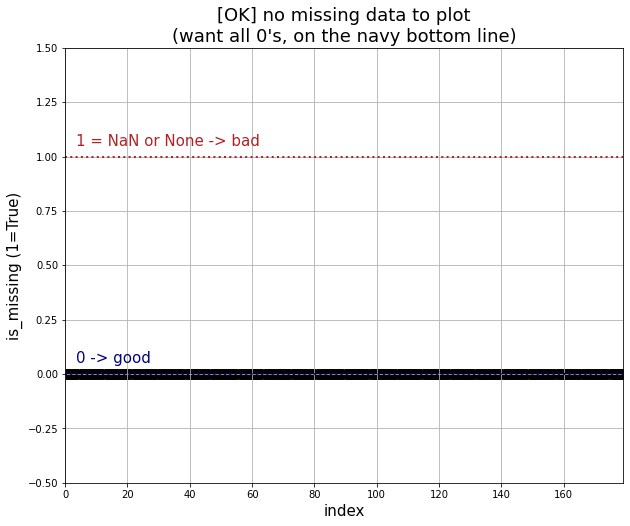

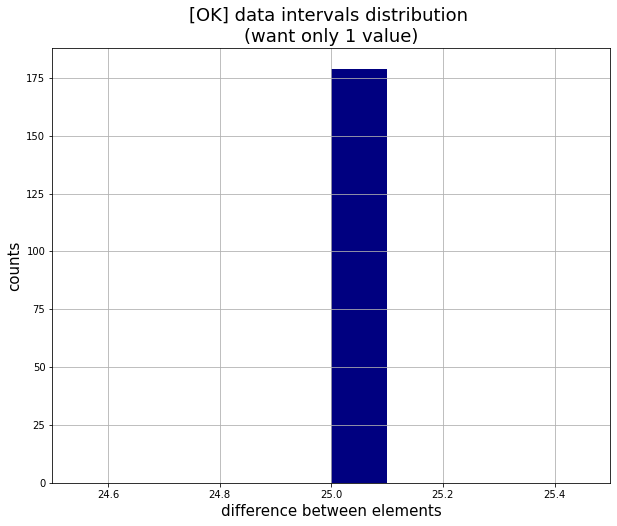

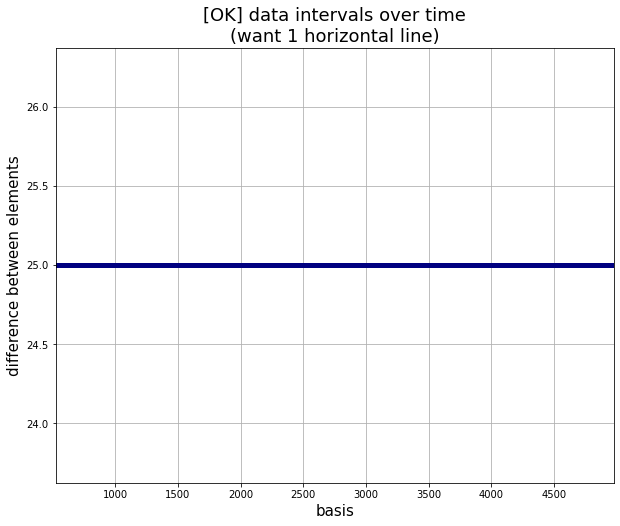

In [43]:
uniform_complete_data: List[int] = list(range(500, 5000, 25))
isli.basis_quality_plots(uniform_complete_data);

### Example with non-uniform spacing
The bottom two plots (color, title, shape) will warn us.

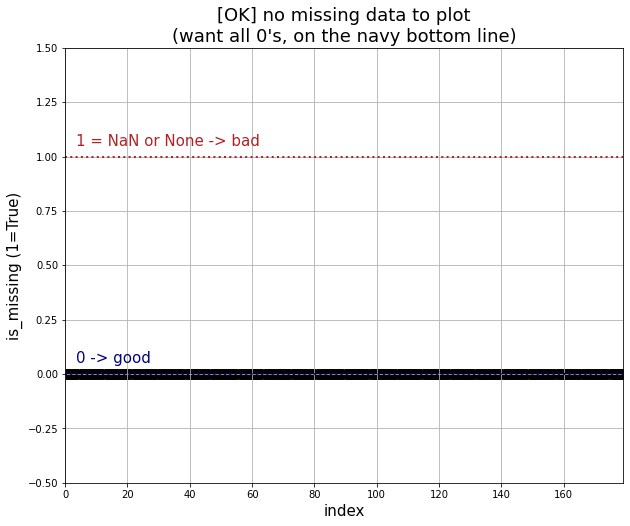

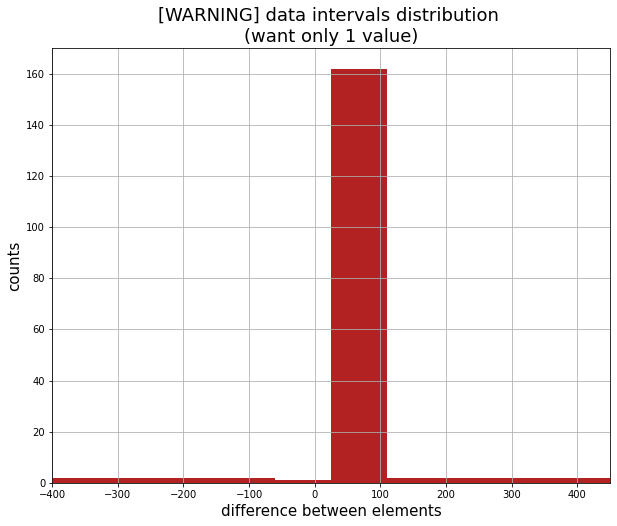

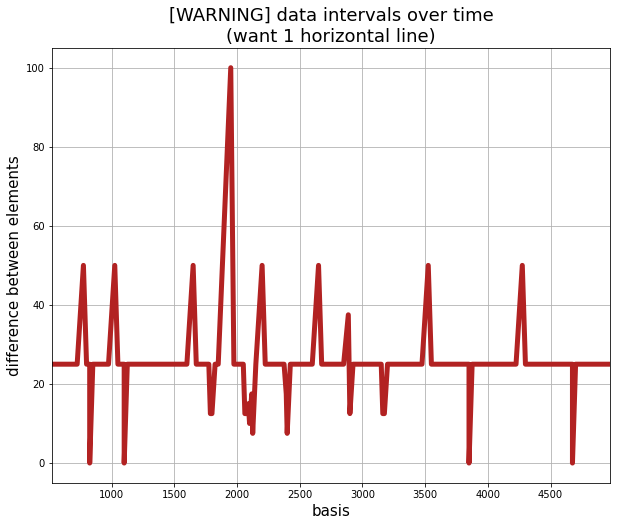

In [44]:
uneven_data = deepcopy(uniform_complete_data)
for index in [10, 20, 45, 55, 56, 57, 67, 85, 95, 120, 150]:
    uneven_data[index] *= 1.1
isli.basis_quality_plots(uneven_data);

### Example with `NaN`s, `None`s, etc
(Note that with missing data the differences cannot be calculated, so requested plots are returned but intentionally left blank).

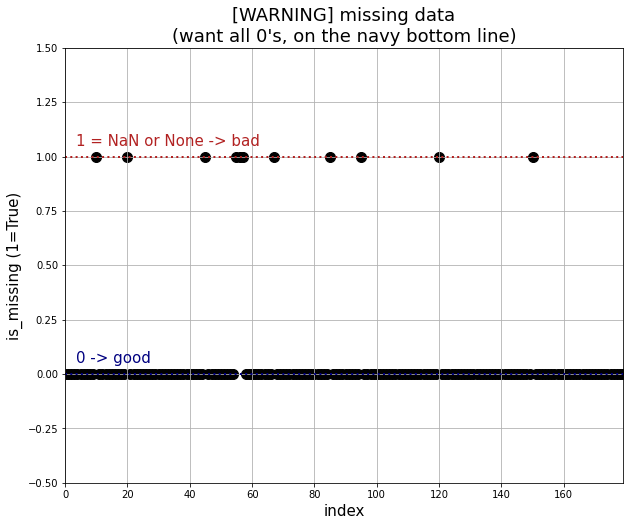

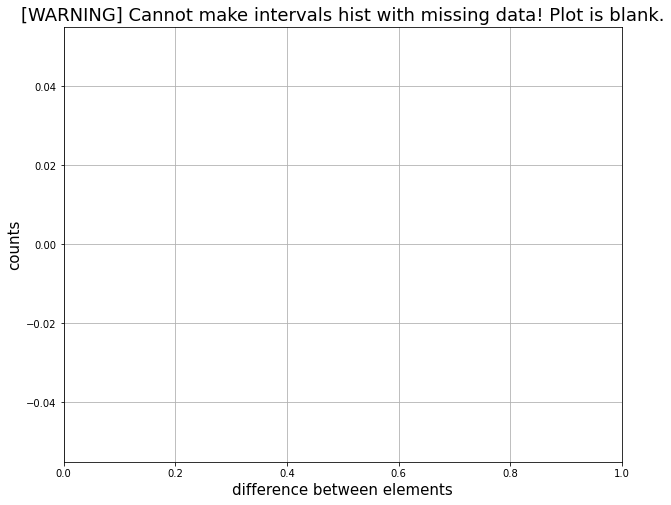

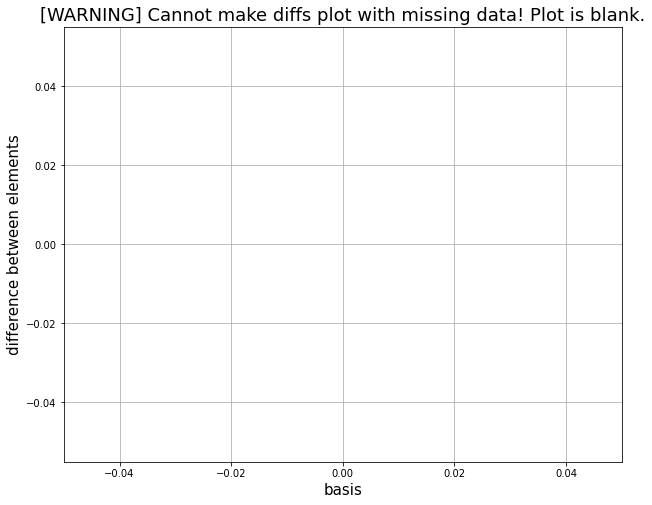

In [45]:
uneven_data = deepcopy(uniform_complete_data)
for index in [10, 20, 45, 55, 56, 57]:
    uneven_data[index] = None
for index in [67, 85, 95, 120, 150]:
    uneven_data[index] = np.nan
isli.basis_quality_plots(uneven_data);

# TODO:

### Demo projection
...

### Demo feature selection
...